# General Overview - Statistical Analysis

* We want to analyze the variables in this dataset to understand any relationships between them and their overall effects.
* To do this,
        * `Chi-square test` for categorical variables relationship
        * We have to analyze numerical variables using `analysis of variance` or `ANOVA test`.
* The purpose of these tests is to determine whether there is a statistically significant relationship between the target variable, readmissions and independent variable. Our p-value is 0.01, if anything above that, we cannot reject the null hypothesis.
* A machine learning model can interpret integers as well as process strings, so we must transform all categorical variables using dummy variables as numeric variables. This takes the string values ​​in a variable and converts them to columns labeled 0 or 1 relative to the string. We will also standardize the original numerical variables with a mean of 0 and a standard deviation of 1.
* Finally, we look at the correlation coefficients between the independent variables to make sure they do not have a strong influence on each other. The threshold we used is -0.7 <x <0.7.



### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

sns.set(style='darkgrid')
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

- We got cleaned dataset in the [first notebook](https://www.kaggle.com/kirshoff/01-exploratory-data-analysis-with-diabetes-dataset)
- We use diabetic_data_cleaned.csv here.

In [ ]:
data = pd.read_csv('../input/diabetic-data-cleaned/diabetic_data_cleaned.csv', index_col=0) # import data
df = data.copy() # save a copy of data as diabetes

In [ ]:
features = pd.read_csv('../input/diabeticdatacleaned/features.csv',index_col='Unnamed: 0')
info = lambda attribute:print(f"{attribute.upper()} : {features[features['Feature']==attribute]['Description'].values[0]}\n")

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(df)

In [ ]:
df.describe().round(2).T

In [ ]:
plt.figure(figsize=(6,6))

explode = [0,0.1]
plt.pie(df['readmitted'].value_counts(),explode=explode,autopct='%1.1f%%',shadow=True,startangle=60)
plt.legend(labels=df.readmitted.value_counts().index)
plt.title('Readmitted Patients')
plt.axis('off')
plt.show()

## Feature Selection
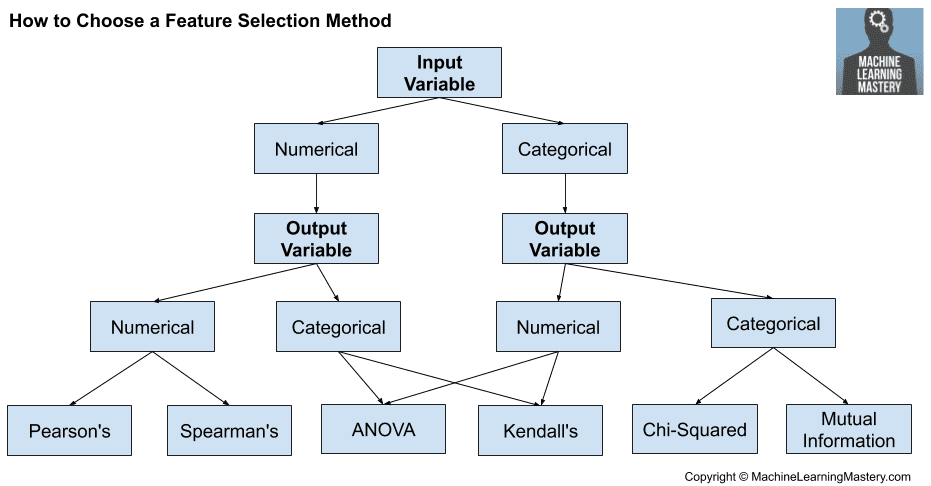

### categorical variables

In [ ]:
print('Unique Values of Each Features:\n')
for i in df:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

In [ ]:
categorical=df.select_dtypes(include='object').columns.tolist()
print(categorical)

* The categorical variables are: 
<br>`['race', 'gender', 'age', 'diag_1', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']`


* We are using the chi-square test for association with a p-value of 0.01 to reject the null hypothesis.

## chi-square test for association

In [ ]:
# define a function that returns a table, a chi-square value, and a p value
def chisquare_test(df, var_list, target, null_list=[]):
    for var in var_list:
        print(var.upper())
        chi_test = pd.crosstab(df[var], df[target])
        display(chi_test)
    
        chisq_value, pvalue, dataframe, expected = chi2_contingency(chi_test)
    
        print(f"""Chi-square value: {chisq_value:.2f}
p-value\t\t: {pvalue:.3f}\n""")
        
        if pvalue > 0.01: # adds variables that fail to reject the null hypothesis
            null_list.append(var)
            
    print(f'Fail to reject null hypothesis: {null_list}')

In [ ]:
cols_cat = ['race','gender', 'age', 'diag_1', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
null_list=[]
chisquare_test(df, cols_cat,'readmitted',null_list)

> Based on the chi-square value and p-value, we can safely say that there is no relation between the independent variables and the target variable.

### medications

In [ ]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
            'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
               'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
               'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-pioglitazone']
chisquare_test(df, medications,'readmitted', null_list)

* The medications: nateglinide, chlorpropamide, glimepiride, acetohexamide, glyburide, tolbutamide, miglitol, troglitazone, tolazamide, glyburide-metformin, glipizide-metformin, and metformin-pioglitazone all failed to pass the test since they have p-values greater than 0.01.

* Since these variables are not independent of the target variable, we are removing them from the dataset.

In [ ]:
print(null_list)

In [ ]:
# drop columns that do not pass the p-value test
df = df.drop(columns=null_list)

# numerical variables

## statistical testing - analysis of variance (ANOVA)

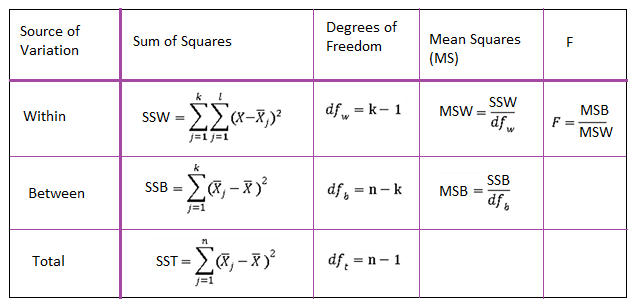

In [ ]:
# The numerical variables 
numerical=df.select_dtypes(include=['int64','float']).columns.tolist()
print(numerical)

* Using the analysis of variance (ANOVA) test, we want to determine if there is a statistically significant relationship between a numerical variable and the categorical target variable. Our p-value threshold is 0.01.

In [ ]:
df.describe().T.round(2)

In [ ]:
# define a function that performs the ANOVA test and returns a table
def anova_table(var_list, null_list=[]):
    for var in var_list:
        print(var.upper())
        
        anova = ols('time_in_hospital ~ {}'.format(var), data=df).fit()
        table = sm.stats.anova_lm(anova, typ=2)
        pvalue=table['PR(>F)'][0]
        if pvalue > 0.01: # adds variables that fail to reject the null hypothesis
            null_list.append(var)
        display(table)
    print(f'Fail to reject null hypothesis: {null_list}')

In [ ]:
anova_vars = ['readmitted']+numerical
anova_table(anova_vars)

> Based on the ANOVA test, we can drop the number of emergency visits since we cannot reject the null hypothesis that the averages for each class are similar, the p-value is greater than our threshold of 0.01.

In [ ]:
# drop number_emergency column
df = df.drop(columns=['number_emergency'])

# One Hot Encoding

Binary columns will be replaced with 0 for No and 1 for Yes. In the gender column, Male and Female will be replaced with 0 and 1 respectively.

In [ ]:
# Unique Values of Each Features
for i in df:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

In [ ]:
df_dummy = pd.get_dummies(df,drop_first=True)
df_dummy.head()

# Are the features that affect readmissions correlated with each other?

If the correlation value is greater than 0.7 or less than -0.7, we have to drop one of the two columns.

The correlation map is quite large for this notebook. Instead, we are going to find each correlation coefficient individually and mark the ones that have a coefficient greater than 0.7 or less than -0.7.

In [ ]:
plt.figure(figsize=(20,5))
df_dummy.corr()["readmitted_YES"].sort_values()[:-1].plot.bar();

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df_dummy.corr(), cmap="coolwarm");

In [ ]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

# prints a descending list of correlation pair (Max on top)
corrank(df_dummy, 0.7)

In [ ]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
df_dummy = remove_collinear_features(df_dummy,0.70)

In [ ]:
df_dummy.shape

# saving machine learning dataset

In [ ]:
# save dataset to new file for machine learning
df_dummy.to_csv('./diabetic_data_cleaned_dummy.csv')